In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random 
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib as mpl
from datetime import timedelta 

In [3]:
mpl.rcParams['figure.dpi']= 150
plt.rcdefaults()

In [4]:
import rmab.secret as secret 
from rmab.database import open_connection, run_query
from rmab.fr_dynamics import get_transitions, compute_days_till, get_data_all_users
from rmab.plots import plot_transition_dynamics

/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
db_name = secret.database_name 
username = secret.database_username 
password = secret.database_password 
ip_address = secret.ip_address
port = secret.database_port

In [6]:
connection_dict = open_connection(db_name,username,password,ip_address,port)
connection = connection_dict['connection']
cursor = connection_dict['cursor']

In [7]:
sample_query = run_query(cursor,"SELECT * FROM RESCUES LIMIT 1")

In [8]:
sample_query[0]

{'id': 282561,
 'donation_id': 239147,
 'recipient_location_id': 7463,
 'published_at': datetime.datetime(2021, 9, 2, 11, 30, 37, 462387),
 'created_at': datetime.datetime(2021, 8, 9, 15, 44, 26, 408096),
 'updated_at': datetime.datetime(2021, 9, 2, 23, 11, 55, 556941),
 'state': 9,
 'user_id': 37683,
 'rescue_group_id': None,
 'distance': Decimal('2.93'),
 'admin_id': None,
 'recipient_name': None,
 'recipient_signature_image_file_name': None,
 'recipient_signature_image_content_type': None,
 'recipient_signature_image_file_size': None,
 'recipient_signature_image_updated_at': None,
 'volunteer_rating': None,
 'volunteer_comment': None,
 'volunteer_social_image_file_name': None,
 'volunteer_social_image_content_type': None,
 'volunteer_social_image_file_size': None,
 'volunteer_social_image_updated_at': None,
 'donor_contact_name': None,
 'donor_contact_phone': None,
 'recipient_contact_name': None,
 'recipient_contact_phone': None,
 'completed_at': None,
 'pickup_start': datetime.dat

## Volunteer Analysis

In [10]:
query = ("SELECT user_id, COUNT(*) AS frequency " 
 "FROM RESCUES " 
 "WHERE PUBLISHED_AT <= CURRENT_DATE "
 "AND USER_ID IS NOT NULL "
 "GROUP BY user_id "
 "ORDER BY frequency DESC ")

In [11]:
volunteer_frequencies = run_query(cursor,query)
user_frequencies = [i['frequency'] for i in volunteer_frequencies]

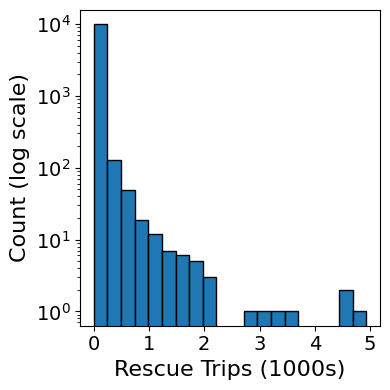

In [15]:
plt.figure(figsize=(4,4))
plt.xlabel('Rescue Trips (1000s)',fontsize=16)
plt.ylabel('Count (log scale)',fontsize=16)
plt.hist(user_frequencies, bins=20, log=True, edgecolor='k')
plt.xticks([0,1000,2000,3000,4000,5000],[0,1,2,3,4,5],fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout() 
# plt.savefig("../figures/fr_dataset/rescue_trips.pdf",dpi=300,bbox_inches='tight')

In [16]:
np.mean(user_frequencies), np.std(user_frequencies)

(33.57634450889785, 151.18199503154307)

In [17]:
query = ("SELECT user_id, "
"MAX(published_at) - MIN(published_at) AS time_difference " 
"FROM RESCUES "
"WHERE PUBLISHED_AT <= CURRENT_DATE "
"AND USER_ID IS NOT NULL "
"GROUP BY user_id"
)

In [18]:
time_served_by_user = run_query(cursor,query)
time_served_by_user = [i['time_difference'].days for i in time_served_by_user]

FileNotFoundError: [Errno 2] No such file or directory: '../figures/fr_dataset/days_served.pdf'

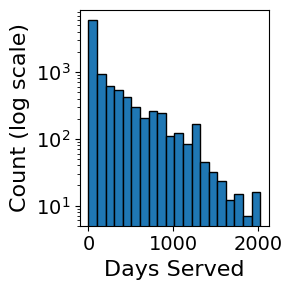

In [19]:
plt.figure(figsize=(3,3))
plt.xlabel('Days Served',fontsize=16)
plt.ylabel('Count (log scale)',fontsize=16)
plt.hist(time_served_by_user, bins=20, log=True, edgecolor='k')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout() 
plt.savefig("../figures/fr_dataset/days_served.pdf",dpi=300,bbox_inches='tight')

In [9]:
data_by_user = get_data_all_users(cursor)

In [138]:
rescues_by_user = [len(data_by_user[i]) for i in data_by_user]
num_users_at_least = []

for i in range(100):
    users_with_i_rescues = [1 for r in rescues_by_user if r>=i]
    num_users_at_least.append(len(users_with_i_rescues))

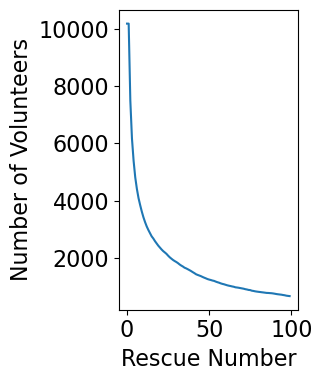

In [118]:
plt.figure(figsize=(3,4))
plt.xlabel("Rescue Number", fontsize=16)
plt.ylabel("Number of Volunteers",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.plot(num_users_at_least)
plt.savefig("../figures/fr_dataset/volunteers_by_trips.pdf",dpi=300,bbox_inches='tight')

In [23]:
differences_between = compute_days_till(data_by_user)
differences_between_5 = compute_days_till(data_by_user,5)
differences_between_10 = compute_days_till(data_by_user,10)
differences_between_20 = compute_days_till(data_by_user,20)
differences_between_50 = compute_days_till(data_by_user,50)

In [46]:
max_gaps = []
for j in data_by_user:
    m = 0
    if len(data_by_user[j])>=5:
        for i in range(len(data_by_user[j])-1):
            m = max(m,(data_by_user[j][i+1]-data_by_user[j][i]).days)
        max_gaps.append(m)
      


In [50]:
np.percentile(max_gaps,90)

402.0

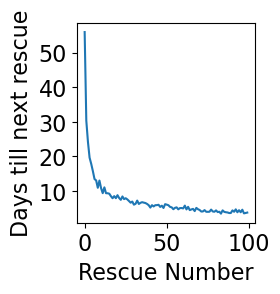

In [129]:
plt.figure(figsize=(3,3))
plt.xlabel("Rescue Number", fontsize=16)
plt.ylabel("Days till next rescue",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.plot(differences_between)
plt.savefig("../figures/fr_dataset/days_till_rescue.pdf",dpi=300,bbox_inches='tight')

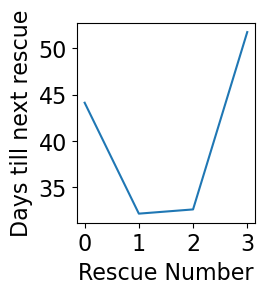

In [130]:
plt.figure(figsize=(3,3))
plt.xlabel("Rescue Number 5", fontsize=16)
plt.ylabel("Days till next rescue",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.plot(differences_between_5)
plt.savefig("../figures/fr_dataset/days_till_rescue_5.pdf",dpi=300,bbox_inches='tight')

NameError: name 'differences_between_10' is not defined

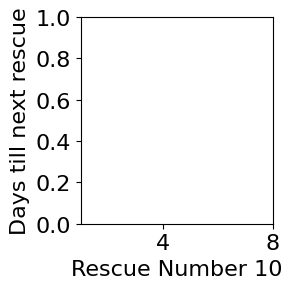

In [20]:
plt.figure(figsize=(3,3))
plt.xlabel("Rescue Number 10", fontsize=16)
plt.ylabel("Days till next rescue",fontsize=16)
plt.xticks([3,7],[4,8],fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.plot(differences_between_10)
plt.savefig("../figures/fr_dataset/days_till_rescue_10.pdf",dpi=300,bbox_inches='tight')

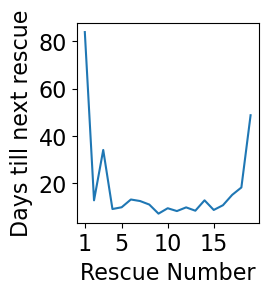

In [134]:
plt.figure(figsize=(3,3))
plt.xlabel("Rescue Number 20", fontsize=16)
plt.ylabel("Days till next rescue",fontsize=16)
plt.xticks([0,4,9,14,19],[1,5,10,15,20],fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.plot(differences_between_20)
plt.savefig("../figures/fr_dataset/days_till_rescue_20.pdf",dpi=300,bbox_inches='tight')

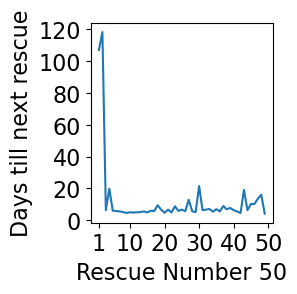

In [135]:
plt.figure(figsize=(3,3))
plt.xlabel("Rescue Number 50", fontsize=16)
plt.ylabel("Days till next rescue",fontsize=16)
plt.xticks([0,9,19,29,39,49],[1,10,20,30,40,50],fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.plot(differences_between_50)
plt.savefig("../figures/fr_dataset/days_till_rescue_50.pdf",dpi=300,bbox_inches='tight')

## Transition Dynamics

In [10]:
all_transitions = {}

for i in range(2,101):
    all_transitions[i] = get_transitions(data_by_user,i)

In [27]:
num_rescues = 5
count_matrix = np.zeros((4,2,4))
for user_id in data_by_user:
    if len(data_by_user[user_id]) == num_rescues:
        start_rescue = data_by_user[user_id][0]
        end_rescue = data_by_user[user_id][-1]

        week_dates = [start_rescue]
        current_date = start_rescue 

        while current_date <= end_rescue:
            current_date += timedelta(weeks=1)
            week_dates.append(current_date) 
        
        has_event = [0 for i in range(len(week_dates))]

        current_week = 0
        for i, rescue in enumerate(data_by_user[user_id]):
            while rescue>week_dates[current_week]+timedelta(weeks=1):
                current_week += 1 
            has_event[current_week] = 1

        while len(has_event) < 5:
            has_event.append(0)

        for i in range(len(has_event)-2):
            if has_event[i] == 1:
                start_state = 0
            elif has_event[i] == 0 and (i == 0 or has_event[i-1] == 1):
                start_state = 1
            elif has_event[i] == 0 and has_event[i-1] == 0 and (i == 1 or has_event[i-2] == 1):
                start_state = 2
            else:
                continue 

            action = has_event[i+1]

            if has_event[i+2] == 0:
                end_state = start_state+1 
            else:
                end_state = 0
            count_matrix[start_state][action][end_state] += 1
for i in range(len(count_matrix)):
    for j in range(len(count_matrix[i])):
        if np.sum(count_matrix[i][j]) != 0:
            count_matrix[i][j]/=(np.sum(count_matrix[i][j]))
count_matrix[3,:,3] = 1

In [28]:
count_matrix[3]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [12]:
has_event

[1, 1, 0, 0, 0]

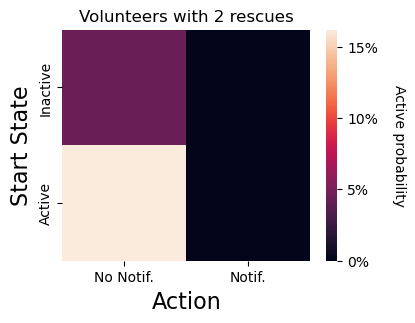

In [140]:
num_rescues = 2
cbar = plot_transition_dynamics(all_transitions[num_rescues])
cbar.set_ticks([0,0.05,0.1,0.15])
cbar.set_ticklabels(['0%','5%','10%','15%'])
plt.title("Volunteers with {} rescues".format(num_rescues))
plt.savefig("../figures/fr_dataset/transitions_2.pdf",dpi=300,bbox_inches='tight')

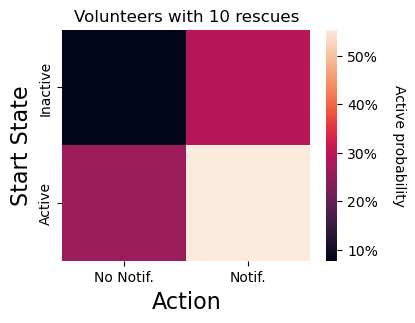

In [141]:
num_rescues = 10
cbar = plot_transition_dynamics(all_transitions[num_rescues])
cbar.set_ticks([0.1,0.2,0.3,0.4,0.5])
cbar.set_ticklabels(['10%','20%','30%','40%','50%'])
plt.title("Volunteers with {} rescues".format(num_rescues))
plt.savefig("../figures/fr_dataset/transitions_10.pdf",dpi=300,bbox_inches='tight')

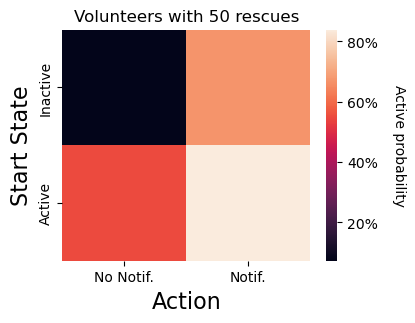

In [142]:
num_rescues = 50
cbar = plot_transition_dynamics(all_transitions[num_rescues])
cbar.set_ticks([0.2,0.4,0.6,0.8])
cbar.set_ticklabels(['20%','40%','60%','80%'])
plt.title("Volunteers with {} rescues".format(num_rescues))
plt.savefig("../figures/fr_dataset/transitions_50.pdf",dpi=300,bbox_inches='tight')

In [143]:
chance_notification_works_inactive = [all_transitions[i][0][1][1] for i in all_transitions]
chance_notification_works_active = [all_transitions[i][1][1][1] for i in all_transitions]

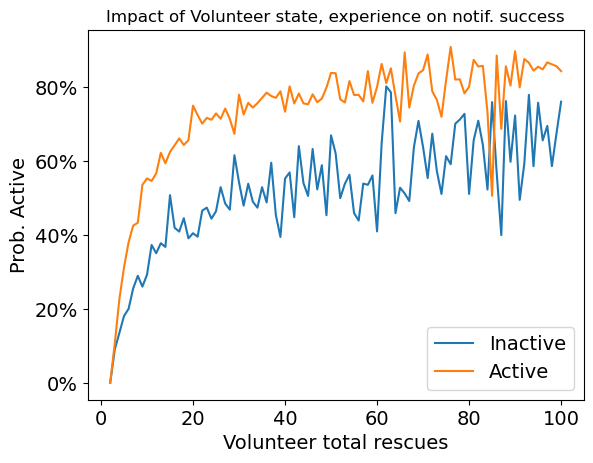

In [144]:
plt.plot(list(range(2,2+len(chance_notification_works_inactive))),chance_notification_works_inactive,label='Inactive')
plt.plot(list(range(2,2+len(chance_notification_works_active))),chance_notification_works_active,label='Active')
plt.xlabel('Volunteer total rescues',fontsize=14)
plt.ylabel('Prob. Active',fontsize=14)
plt.yticks([0.0,0.2,0.4,0.6,0.8],['0%','20%','40%','60%','80%'],fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.title("Impact of Volunteer state, experience on notif. success")
plt.savefig("../figures/fr_dataset/notification_success.pdf",dpi=300,bbox_inches='tight')

In [145]:
chance_silence_works_inactive = [all_transitions[i][0][0][1] for i in all_transitions]
chance_silence_works_active = [all_transitions[i][1][0][1] for i in all_transitions]

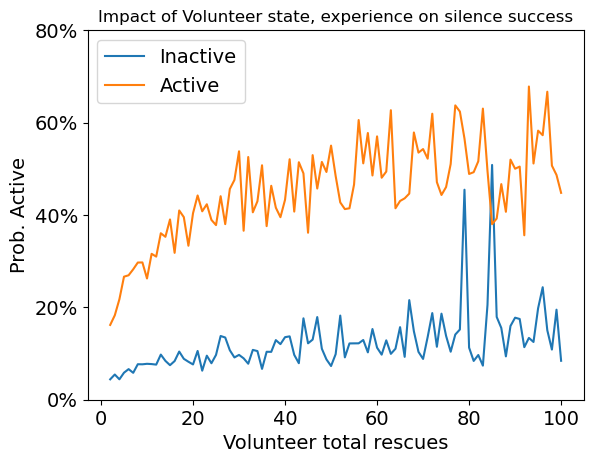

In [146]:
plt.plot(list(range(2,2+len(chance_silence_works_inactive))),chance_silence_works_inactive,label='Inactive')
plt.plot(list(range(2,2+len(chance_silence_works_active))),chance_silence_works_active,label='Active')
plt.xlabel('Volunteer total rescues',fontsize=14)
plt.ylabel('Prob. Active',fontsize=14)
plt.yticks([0.0,0.2,0.4,0.6,0.8],['0%','20%','40%','60%','80%'],fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.title("Impact of Volunteer state, experience on silence success")
plt.savefig("../figures/fr_dataset/silence_success.pdf",dpi=300,bbox_inches='tight')